In [1]:
library(tidyverse)
library(ggpubr)
library(yaml)
library(patchwork)

#read config
config <- read_yaml(file = "../CHARM/config.yaml")

#Common
Raw <- read_table2("../stat/raw.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3],X1 = strsplit(X1,split = "_")[[1]][1])
DNA <- read_table2("../stat/dna.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise()%>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3])
RNA <- read_table2("../stat/rna.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3])

raw_pairs <- read_table2("../stat/raw.pairs.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])
pairs_dedup <- read_table2("../stat/pairs.dedup.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])

pairs_c1 <- read_table2("../stat/pairs.c1.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
pairs_c12 <- read_table2("../stat/pairs.c12.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
pairs_c123 <- read_table2("../stat/pairs.c123.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
inter_pairs_c123 <- read_table2(file = "../stat/inter.pairs.c123.stat",col_names = F) %>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))

yperx <- read_table2("../stat/yperx.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][2])
stat <- Raw %>% left_join(DNA,by="X1") %>% left_join(RNA,by="X1") %>% left_join(yperx,by="X1") %>% left_join(raw_pairs,by="X1") %>% left_join(pairs_dedup,by="X1") %>% 
    left_join(pairs_c1,by="X1") %>% left_join(pairs_c12,by="X1")%>% left_join(pairs_c123,by="X1") %>% left_join(inter_pairs_c123,by="X1")
RNAres <- read_table2("../result/RNA_Res/counts.gene.total.format.tsv")
featureStat <- cbind(as.data.frame(colSums(RNAres %>% select(-gene))),colSums(RNAres %>% select(-gene) != 0)) %>% rownames_to_column("X1")
RNAresExon <- read_table2("../result/RNA_Res/counts.exon.total.format.tsv")
featureStatExon <- cbind(as.data.frame(colSums(RNAresExon %>% select(-gene))),colSums(RNAresExon %>% select(-gene) != 0))  %>% rownames_to_column("X1")

if(config$if_RNA_snp_split){
    RNAresGenome1 <- read_table2("../result/RNA_Res/counts.gene.genome1.tsv")
    RNAresGenome2 <- read_table2("../result/RNA_Res/counts.gene.genome2.tsv")
    featureStatGenome1 <- cbind(as.data.frame(colSums(RNAresGenome1 %>% select(-gene))),colSums(RNAresGenome1 %>% select(-gene) != 0)) %>% rownames_to_column("X1")
    featureStatGenome2 <- cbind(as.data.frame(colSums(RNAresGenome2 %>% select(-gene))),colSums(RNAresGenome2 %>% select(-gene) != 0)) %>% rownames_to_column("X1")
    stat <- stat %>% left_join(featureStat,by="X1") %>% left_join(featureStatExon,by="X1") %>% left_join(featureStatGenome1,by="X1")  %>% left_join(featureStatGenome2,by="X1")
    names(stat) <- c("cellname","Rawreads","DNAreads","RNAreads","yperx","raw_pairs","pairs_dedup","pairs_clean1","pairs_clean2","pairs_clean3","inter_pairs_clean3",
                     "UMIs_gene","genes_gene","UMIs_exon","genes_exon","UMIs_gene_genome1","genes_gene_genome1","UMIs_gene_genome2","genes_gene_genome2")
} else{
    stat <- stat %>% left_join(featureStat,by="X1") %>% left_join(featureStatExon,by="X1") 
    names(stat) <- c("cellname","Rawreads","DNAreads","RNAreads","yperx","raw_pairs","pairs_dedup","pairs_clean1","pairs_clean2","pairs_clean3","inter_pairs_clean3",
                     "UMIs_gene","genes_gene","UMIs_exon","genes_exon")
}

if(config$if_structure){
    rmsd <- read_table2("../stat/rmsd.info",col_names = F) %>% rowwise() %>% mutate(X1=str_split(X1,pattern = fixed("/")),cellname = X1[1], res = str_split(X1[3], fixed("."))[[1]][2],TOP3_RMSD = X5) %>% select(cellname,res,TOP3_RMSD) %>% spread(res,TOP3_RMSD) %>% arrange(cellname)
    stat <- stat %>% left_join(rmsd)
}

if (config$if_charm){
    reads <- tibble("cellname"=NA)
    for(i in 1:length(names(config$split))){
        temp <- read_csv(paste0("../stat/",names(config$split)[i],".read.stat"),col_names = F) %>% rowwise() %>% mutate(X2 = X2*300/1000000000)
        names(temp) <- c("cellname",paste0(names(config$split)[i],"_reads"))
        reads <- reads %>% full_join(temp)
    }
    reads <- reads %>% filter(!is.na(cellname))
    stat <- stat %>% full_join(reads)
}

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.2”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

In [2]:
plot <- stat %>% mutate(RNAreadsRatio = RNAreads/(RNAreads+DNAreads),
                        pairsPerRead = raw_pairs/DNAreads/1000000000*300,
                        pairsValidRatio = pairs_clean3/raw_pairs,
                        interPairsRatio = inter_pairs_clean3/pairs_clean3) 
plot[is.na(plot)]<-0

In [3]:
options(repr.matrix.max.cols=100, repr.matrix.max.rows=20)
plot

cellname,Rawreads,DNAreads,RNAreads,yperx,raw_pairs,pairs_dedup,pairs_clean1,pairs_clean2,pairs_clean3,inter_pairs_clean3,UMIs_gene,genes_gene,UMIs_exon,genes_exon,1m,200k,20k,50k,ct_reads,atac_reads,RNAreadsRatio,pairsPerRead,pairsValidRatio,interPairsRatio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MB1,2.494011,2.393187,0.0873459,0.002327,2910488,685376,674428,596313,596187,279843,9142,4685,1718,1178,1.642159e-03,0.03912695,0.3448013,0.13214933,0.24533452,0.11751847,0.03521255,0.3648467,0.2048409,0.4693880
MB2,2.034532,1.962729,0.0619401,0.001720,2401376,602073,593798,521774,521643,272253,10367,4783,1880,1310,7.430388e-03,0.07782958,0.6712903,0.31030180,0.22678538,0.11393543,0.03059271,0.3670466,0.2172267,0.5219144
MB3,2.999379,2.867744,0.1151706,0.002423,3468537,682969,672660,599814,599677,278808,13130,5224,2234,1474,5.147521e-03,0.03428305,0.3837553,0.14880461,0.21662377,0.20520105,0.03861008,0.3628500,0.1728905,0.4649303
MB4,4.196399,4.022158,0.1510638,0.001896,5158787,916423,899865,839910,839805,433778,6683,4087,1318,885,6.300549e-05,0.02186469,0.1627870,0.05802599,0.31236683,0.20540453,0.03619836,0.3847775,0.1627912,0.5165223
MB5,2.711750,2.581048,0.1134639,0.001417,3177252,712451,701751,634689,634566,339524,10600,4925,2033,1360,8.846797e-03,0.03298787,0.4387889,0.19488069,0.20823885,0.14618648,0.04210927,0.3692980,0.1997216,0.5350492
MB6,2.874636,2.688601,0.1619514,0.001124,3250005,679111,665478,592105,591992,295108,10678,5554,2280,1414,7.373894e-01,1.25648987,4.0474771,2.81629619,0.25904843,0.14747130,0.05681404,0.3626427,0.1821511,0.4985000
MB7,2.630140,2.524951,0.0909624,0.001603,3060552,697815,688051,605115,604953,273101,10031,4922,1959,1388,8.243509e-03,0.05114732,0.4068472,0.18644780,0.23200995,0.16223640,0.03477270,0.3636369,0.1976614,0.4514417
MB7356,2.758682,2.569281,0.1600440,0.001883,3164363,766292,755236,678838,678663,308769,12056,5417,2424,1610,1.452542e-02,0.04998893,0.3852895,0.16976970,0.17614747,0.12817680,0.05863867,0.3694843,0.2144707,0.4549666
MB8,2.465047,2.365851,0.0863178,0.001484,2872706,668832,658824,582067,581919,279777,12931,5284,2219,1566,1.917353e-02,0.06603174,0.5052429,0.23764219,0.30420412,0.13175872,0.03520059,0.3642713,0.2025682,0.4807834


In [4]:
library(ArchR) %>% suppressMessages()

addArchRThreads(threads = 20) 
addArchRGenome("mm10")

Warning message:
“package ‘gridExtra’ was built under R version 4.2.1”
Warning message:
“package ‘gtable’ was built under R version 4.2.3”
Warning message:
“package ‘magrittr’ was built under R version 4.2.1”
Warning message:
“package ‘data.table’ was built under R version 4.2.2”
Warning message:
“package ‘Matrix’ was built under R version 4.2.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.2.2”
Setting default number of Parallel threads to 20.

Setting default genome to Mm10.



In [6]:
inputFiles <- c("../result/fragments/atac.fragments.bgz",
                "../result/fragments/ct.fragments.bgz")
names(inputFiles) <- c("ATAC","CT")
#inputFiles

ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 0, #Dont set this too high because you can always increase later
  minFrags = 500, 
  maxFrags = Inf,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  force = TRUE,
  excludeChr = c("chrM", "chrY","chrX"),
)
proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "CHARM",
  copyArrows = TRUE, #This is recommened so that you maintain an unaltered copy for later usage. 
) %>% suppressMessages()

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

ArchR logging to : ArchRLogs/ArchR-createArrows-ac5c6ab1f9ce-Date-2023-06-03_Time-20-27-39.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-06-03 20:27:39 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-ac5c6ab1f9ce-Date-2023-06-03_Time-20-27-39.log



ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-ac5c62604b4c-Date-2023-06-03_Time-20-30-46.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-ac5c62604b4c-Date-2023-06-03_Time-20-30-46.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-ac5c2c1e02cb-Date-2023-06-03_Time-20-30-54.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-ac5c2c1e02cb-Date-2023-06-03_Time-20-30-54.log



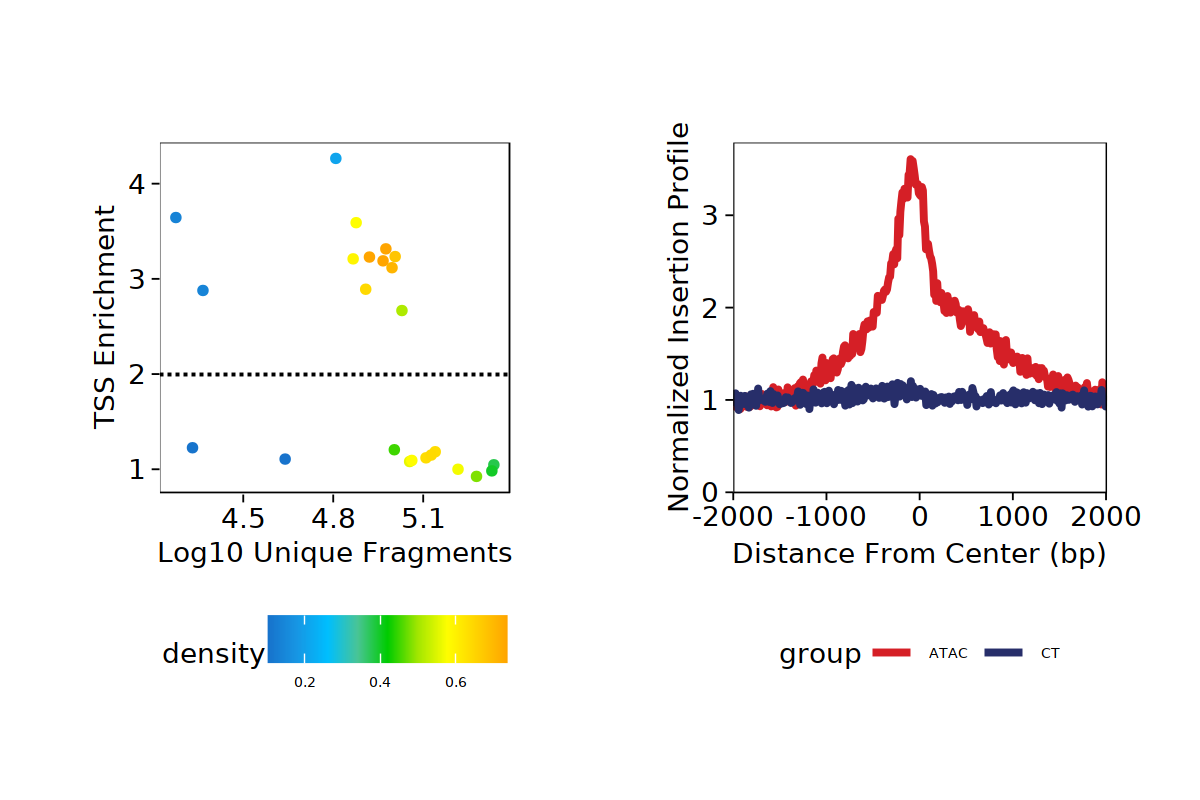

In [7]:
options(repr.plot.height = 4, repr.plot.width = 6,repr.plot.res =200)
df <- getCellColData(proj, select = c("log10(nFrags)", "TSSEnrichment"))
p2 <- ggPoint(
  x = df[, 1],
  y = df[, 2],
  labelMeans = TRUE,
  colorDensity = TRUE,
  continuousSet = "sambaNight",
  xlabel = "Log10 Unique Fragments",
  ylabel = "TSS Enrichment",
  #xlim = c(log10(50000), quantile(df[, 1], probs = 0.99)),
  #ylim = c(0, quantile(df[, 2], probs = 0.99))
) + geom_hline(yintercept = 2, lty = "dashed") + geom_vline(xintercept = 3, lty = "dashed")

p1 <- plotFragmentSizes(ArchRProj = proj)
p3 <- plotTSSEnrichment(proj,flank = 2000)
p2 | p3

In [21]:
df%>% as.data.frame() %>% mutate(frags = 10^log10.nFrags.) %>% rownames_to_column("cellname") -> df

# 首先将cellname拆分成两个新的列
df <- df %>% separate(cellname, into = c("type", "cellname"), sep = "#") %>% select(-log10.nFrags.)

df <- df %>%
  pivot_wider(names_from = type, values_from = c(TSSEnrichment, frags), names_sep = "_")

names(df) <- c("cellname", "ct_tssenrichment", "atac_tssenrichment", "ct_fragments", "atac_fragments")

df


cellname,ct_tssenrichment,atac_tssenrichment,ct_fragments,atac_fragments
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MB2,1.047,2.667,216571,106935
MB8,0.983,3.315,213248,94521
MB8356,0.925,3.229,189544,83327
MB1,1.000,2.891,164462,80966
MB7,1.184,3.117,138047,99092
MB6,1.149,3.210,133838,73520
MB7356,1.120,3.189,128639,92498
MB3,1.093,3.234,115333,101506
MB5,1.081,3.590,113440,75236


In [26]:
plot %>% full_join(df) -> plot

Joining with `by = join_by(cellname)`


In [27]:
plot %>% write_tsv("../metadata_raw.tsv")